In [1]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline

print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [2]:
# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

In [3]:
# Retail forecasting configuration
target = "Sales"        # Column name containing sales values to forecast
prediction_length = 13  # Number of days to forecast ahead
id_column = "id"        # Column identifying different products/stores
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "1"     # Specific time series to visualize (product/store ID)
batch_size=20

In [11]:
# Load historical sales and past values of covariates
sales_context_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/retail_sales/train.parquet"
    )
sales_context_df[timestamp_column] = pd.to_datetime(sales_context_df[timestamp_column])


# Load future values of covariates
sales_test_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/retail_sales/test.parquet"
    )
sales_test_df[timestamp_column] = pd.to_datetime(sales_test_df[timestamp_column])
sales_future_df = sales_test_df.drop(columns=target)

#display(sales_context_df.head())
#display(sales_future_df.head())

In [6]:
# Generate predictions with covariates
sales_pred_df = pipeline.predict_df(
    sales_context_df,
    future_df=sales_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)

# Comparison: forecast without covariates
sales_pred_no_cov_df = pipeline.predict_df(
    sales_context_df[[id_column, timestamp_column, target]],
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)

# Cross-learning enabled for joint prediction
# This assigns the same group ID to all time series, allowing information sharing
joint_pred_df = pipeline.predict_df(
    sales_context_df,
    future_df=sales_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
    cross_learning=True,
    batch_size=batch_size,
)

#display(sales_pred_df.head())
#display(sales_pred_no_cov_df.head())
#display(joint_pred_df.head())

In [8]:
# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    plt.show()

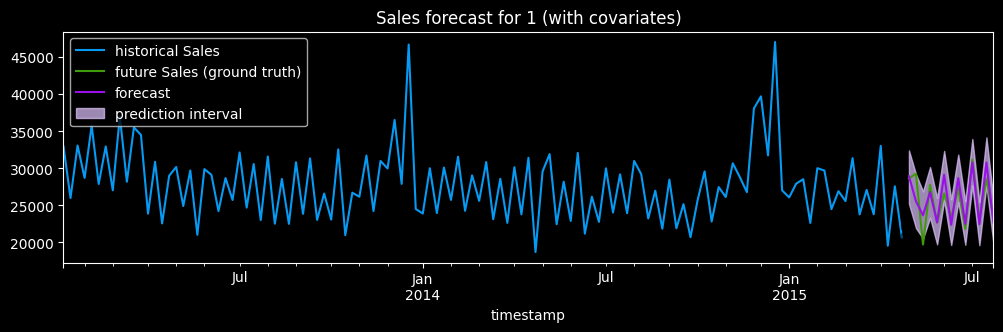

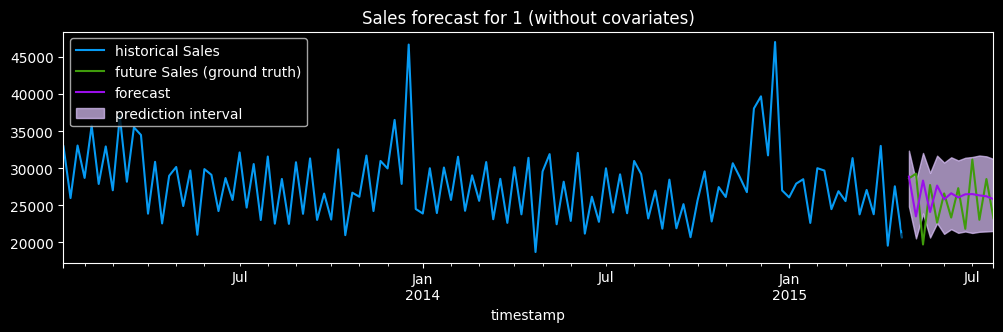

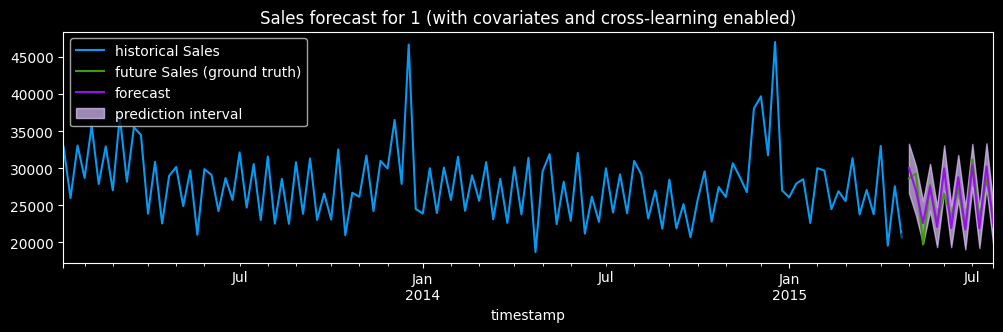

In [9]:
# Visualize forecast with covariates
plot_forecast(
    sales_context_df,
    sales_pred_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)

plot_forecast(
    sales_context_df,
    sales_pred_no_cov_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(without covariates)",
)
plot_forecast(
    sales_context_df,
    joint_pred_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates and cross-learning enabled)",
)

Chronos-2's univariate forecast is nearly flat with high uncertainty. In contrast, the forecast with covariates leverages promotion and holiday information to capture the true sales dynamics over the forecast horizon.